**EM Algorithm** (Expectation - Maximization)

We're going to implement the EM algorithm for a mixture of Bernoullis

The Expectation-Maximization algo. is used in sk-learn, for instance in GMMs: http://scikit-learn.org/stable/modules/mixture.html#estimation-algorithm-expectation-maximization

Additional notes are available here: https://allauzen.github.io/articles/MixturesAndEM/


## Think for a bit

Is EM a supervised or unsupervised learning algorithm ? 

What kind of data set is MNIST ? 

Then, what are we going to do ?  How is this called ?




## Implement the EM algo. for a mixture of Bernoulli (laws)
- The cluster number K should be an argument of the function
- A maximum number of iterations, *MaxIt*, should act as stopping condition
- During the E step, compute and *store* the log-likelihood of the data, so as to monitor its evolution along iterations (~epochs)

Apply the algorithm on MNIST:
- try out K=5,10,15
- Visualize the images coresponding to each cluster's paraemeters. Would that be as straightforward in a Gaussian model (visualizing all the model's parameters?)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 

In [3]:
## we load the whole data set at once, so as to manipulate it directly (using numpy arrays)
## for very large data sets, one needs to read on-the-fly (at least at production time, not at the debugging stage)

# ## Load the dataset -- (python2)
# import cPickle, gzip
# with gzip.open('./tp1-mnist.pkl.gz','rb') as f :
#     train_set, valid_set, test_set = cPickle.load(f)

### Load the dataset -- (python3)
import pickle, gzip
with gzip.open('./mnist.pkl.gz','rb') as f :
    u = pickle._Unpickler( f )
    u.encoding = 'latin1'
    train_set, valid_set, test_set = u.load()

## split train an dtest data, to avoid inadvertently cheating.
unlabelled_dataset = train_set[0].copy()
labels_for_final_accuracy_measurement = train_set[1].copy()
del train_set

## these would be useful, for now we don't use them
del valid_set  
del test_set

In [4]:
unlabelled_dataset

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
unlabelled_dataset.shape

(50000, 784)

In [6]:
## binarize so as to go into Bernoulli-space
threshold = 0.3
for i in range(unlabelled_dataset.shape[0]): 
    unlabelled_dataset[i,:]= 1.0*(unlabelled_dataset[i]>threshold)
## (unlabelled_dataset[i]>threshold) is now an array of Booleans

In [7]:
## inspect the new values "by hand", to check.
unlabelled_dataset[0][300:400] ## reading 
## we do NOT convert to Integers, instead we stay in floats. Because we'll compute averages later (thus, divide..)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [8]:
## for debugging, we may want to use a small piece of the sample
subSampling = 100  ## data size will be divided by a factor "subSampling"
## in the end, we may use all of it (set this to 1) 

## sort data to make sure all classes are equally present ##
ordre = np.argsort(labels_for_final_accuracy_measurement)
unlabelled_dataset = unlabelled_dataset[ordre]
labels_for_final_accuracy_measurement = labels_for_final_accuracy_measurement[ordre]

## do the sub-sampling
dataset = unlabelled_dataset[::subSampling].copy()
subSampledLabels = labels_for_final_accuracy_measurement[::subSampling].copy()

In [9]:
## check it:
subSampledLabels[:10000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [60]:
theta[i]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [34]:
## when you code, start by writing on a copy of the data 
## (not the data themselves: otherwise on the second run of the jupyter cell, you'll have run twice)
K=10
MaxIt=4

data = dataset
eps = 10**(-8)
## compute the proba of an image xi, 
## given its cluster k and parameters theta 
def compute_P_Xi_given_k_and_theta(xi, k, theta):
    tmp =  np.dot(xi , np.log(theta[k]+eps)) + np.dot(1 - xi , np.log(1 -theta[k]+eps))
    output= np.sum(tmp)
    return output


xi = np.zeros((784 ,))
k= 3
theta = np.zeros((K, 784)) 

outputForDebug = compute_P_Xi_given_k_and_theta(xi, k, theta)

In [35]:
outputForDebug

7.839999913152624e-06

In [177]:
## python-note: at debug time, don't write a function, instead, write directly in the main
## when evreything works well, encapsulate the piece of code into a function for later re-use (and lisibility)
def AlgoEM(dataset, K, MaxIt, labels_for_final_accuracy_measurement):

    ## we set the seed to a constant so as to have repeatable experiences 
    ## (at debug time, and when comparing hyper-parameters)
    np.random.seed(42)

    ## we'll assume dataset[i,j] is the value of pixel j of image i.
    Nex = (dataset.shape)[0] ## number of examples (= number of images)
    dim = (dataset.shape)[1] ## dimension of parameters space (=number of pixels per image, in the Bernoulli case)
    classFrequencies = np.zeros(K) ## denoted pi_k 
    theta = np.zeros((K, dim))   ## denoted theta_{k,j}
    list_likelihood = []
    ## initialization ##
    affectations = np.random.random((K, Nex)) ## denoted a_{k,i}
    ## normalization step (needed to make the )
    for i in range(Nex):
        affectations[:,i] /= np.sum(affectations[:,i])


    ## main loop ##
    for iteration in range(0,10,1):
        # if iteration%10 == 0:
        #     print("iteration numero"+str(iteration))

        ######################
        ## step M: update of "pi_k, mu_k" (classFrequencies, theta)  ##
        for i in range(K):
            classFrequencies[i] = np.sum(affectations[i]) / np.sum(affectations)


        theta = np.dot(affectations, data )
        for i in range(K):
            theta[i] /= np.sum(affectations[i]) 


        ## step E: update of "a_ik" (affectations) ##
        for i in range(K):
            for j in range (Nex):
                affectations[i][j] =  classFrequencies[i] * np.exp(compute_P_Xi_given_k_and_theta(dataset[j], i, theta)) 
        for i in range(Nex):
                affectations[:,i] /= np.sum(affectations[:,i])
        ## monitoring of the quality of te clustering ##
        LogLikelihood = np.log(np.max(affectations, axis=0)) 
        print(np.mean(LogLikelihood))
        ## TODO: record the monitoring into an array, to be able to later plot it
        list_likelihood.append(np.mean(LogLikelihood))
    return affectations, theta, classFrequencies, list_likelihood
    ##########################################################################


In [192]:
K=20

In [193]:
affectations, theta, classFrequencies, list_likelihood = AlgoEM(dataset, 20, K, labels_for_final_accuracy_measurement)

-1.0490865409046544
-0.05153767031414196
-0.010894693802417133
-0.008017125630476078
-0.0035851280908602164
-0.002604623870028167
-0.002744859740971877
-0.0018619760730811043
-0.0017695911013907882
-0.0006549470589686542


In [194]:
list_likelihood

[-1.0490865409046544,
 -0.05153767031414196,
 -0.010894693802417133,
 -0.008017125630476078,
 -0.0035851280908602164,
 -0.002604623870028167,
 -0.002744859740971877,
 -0.0018619760730811043,
 -0.0017695911013907882,
 -0.0006549470589686542]

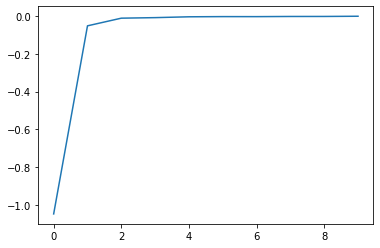

In [195]:
plt.plot(list_likelihood)

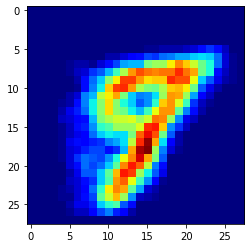

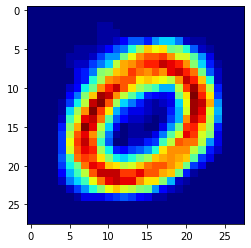

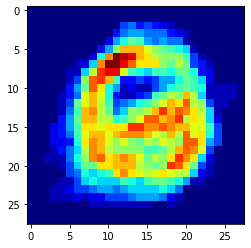

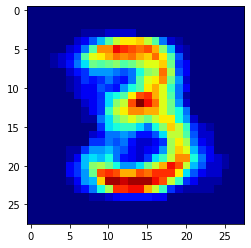

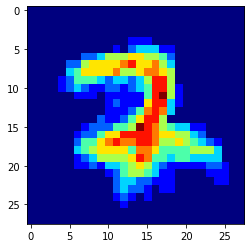

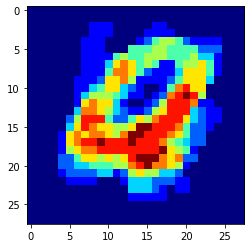

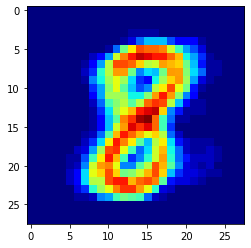

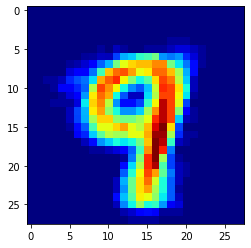

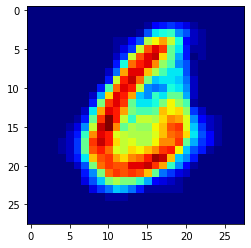

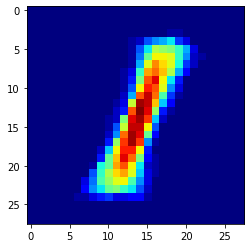

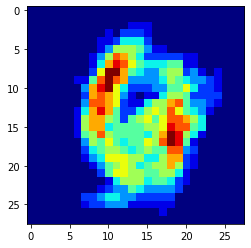

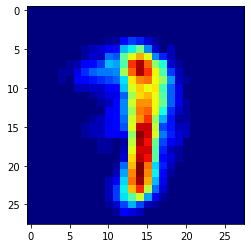

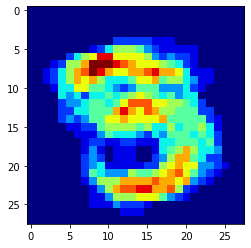

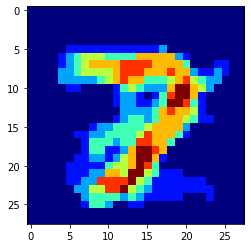

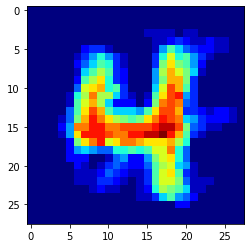

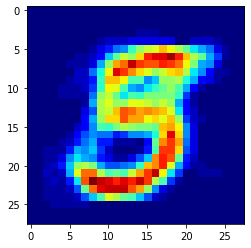

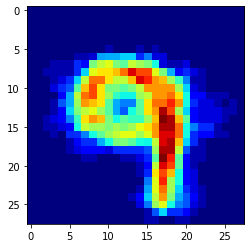

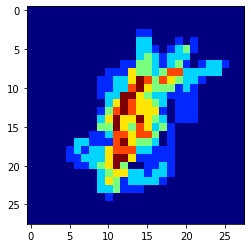

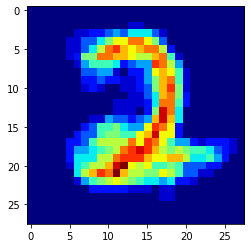

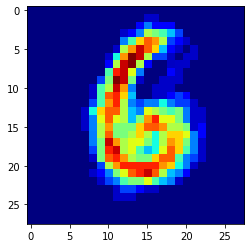

In [196]:
## we can visualize the parameters theta, cluster by cluster
for k in range(K):
    plt.imshow(theta[k].reshape(28,28) , matplotlib.pyplot.cm.jet)
    matplotlib.pyplot.show()

TODO: after checking your code works, put it inside a function and call that function 
 (instead of running code in the *main()* directly)

In [198]:
K=10

In [200]:
 affectations, theta, classFrequencies,_ = AlgoEM(dataset, K, MaxIt , labels_for_final_accuracy_measurement)

-0.7483606583716702
-0.03882804616681269
-0.007466435400843677
-0.006692015697801194
-0.00508446998461291
-0.0008355262442210657
-0.002137809773903627
-0.002886161291686663
-0.001640643092955058
-0.0031315924953178556


Now, let's monitor something more interpretable than the log-likelihood... what could it be ? 

Trick: you may use the function np.argmax(), and maybe just a couple of labels from a couple of examples

**Quesiton**: would this strategy be possible for a purely unsupervised task ?

In [201]:
## TODO: (later) 
## what , 0,1,2,...9
prediction = np.argmax(affectations, axis=0)
score = np.mean(prediction == labels_for_final_accuracy_measurement[:subSampling])
print(score)

0.0


C:\Users\berte\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


Now add this interesting metric into your function, and add some plot of it from the function as well (possibly along wth the log-likelihood plot)

Now, you may play with the hyper-parameters.

What is the best value of the main hyper-parameter ? Explain why.